In [78]:
import pandas as pd
import numpy as np
import datetime
import praw
from collections import Counter
import string
from operator import itemgetter

import requests
import requests.auth
import pandas as pd
import time
import json
import time
import boto3
import ast

import re

import nltk
nltk.download('stopwords')
nltk.download('names')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import names
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer 

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.models import HdpModel
from gensim.utils import lemmatize

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jakob.barke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     /Users/jakob.barke/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jakob.barke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jakob.barke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jakob.barke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Reading in the data

Note on below: I downloaded the data.txt file from the S3 bucket using the credentials that Sanjeev emailed out. I saved the data.txt file in a different folder, not the one that this notebook is in. I don't want to be pushing and pulling 47k stories to github.

Also, if Jupyter notebook gives you some rate limit issue opening the file in here (it did for me), you can fix that by following the directions in this link: https://stackoverflow.com/questions/43288550/iopub-data-rate-exceeded-in-jupyter-notebook-when-viewing-image

In [2]:
d = {"author": [], "author_fullname": [], "full_link": [], "id": [], "score": [], "selftext": [], "title": [], "sortKey": []}
with open("../nosleep-data/data.txt") as f:
        for line in f:
            line = ast.literal_eval(line)
            d["author"].append(line["author"])
            d["author_fullname"].append(line["author_fullname"])
            d["full_link"].append(line["full_link"])
            d["id"].append(line["id"])
            d["score"].append(line["score"])
            d["selftext"].append(line["selftext"])
            d["title"].append(line["title"])
            d["sortKey"].append(line["sortKey"])

In [3]:
story_df = pd.DataFrame(data=d)
story_df.head()

,author,author_fullname,full_link,id,score,selftext,title,sortKey
0,GloriousWilliam666,t2_2uxklusg,https://www.reddit.com/r/nosleep/comments/abf5...,abf59b,1,It was 10:30 of new years night. I was sitting...,New Year's Demon,1546491600
1,Offic3r_Friendly,t2_2ukwz8im,https://www.reddit.com/r/nosleep/comments/abf8...,abf8by,1,\n\nI've worked in security for approximately...,It lives underneath the Campus,1546491600
2,iamanovelty,t2_h4aqm,https://www.reddit.com/r/nosleep/comments/abfa...,abfav7,1,I decided to start pet-sitting again.\n\nThis ...,Someone Swapped My Chinchillas and I Don't Kno...,1546491600
3,John_Drinks,t2_2vo97ouc,https://www.reddit.com/r/nosleep/comments/abfb...,abfbj9,1,"\n\nSince the passing of my wife, I have bee...",An Appalachian Horror Story. Chapter One.,1546491600
4,claire_e_albers,t2_2k4wz7bm,https://www.reddit.com/r/nosleep/comments/abfk...,abfk8f,1,The women howled with laughter as they finishe...,Eyes On the Road,1546491600


In [4]:
story_df.shape

(47125, 8)

In [5]:
story_df = story_df.drop(columns = ['author_fullname','full_link','id','score','sortKey'])
story_df.head()

,author,selftext,title
0,GloriousWilliam666,It was 10:30 of new years night. I was sitting...,New Year's Demon
1,Offic3r_Friendly,\n\nI've worked in security for approximately...,It lives underneath the Campus
2,iamanovelty,I decided to start pet-sitting again.\n\nThis ...,Someone Swapped My Chinchillas and I Don't Kno...
3,John_Drinks,"\n\nSince the passing of my wife, I have bee...",An Appalachian Horror Story. Chapter One.
4,claire_e_albers,The women howled with laughter as they finishe...,Eyes On the Road


In [8]:
x_train, x_test = train_test_split(story_df, test_size=0.15, random_state=42)

In [9]:
x_train.shape

(40056, 3)

# Data Cleaning

In [39]:
def preprocess(df,col):
    print("Removing punctuation")
    df['processed'] = df[col].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    
    print("Making all lower case")
    df['processed'] = df['processed'].map(lambda x: x.lower())
    
    print("Removing stop words and names")
    combined_stops = names.words('male.txt')
    combined_stops.extend(stopwords.words('english'))
    combined_stops.extend(names.words('female.txt'))
    combined_stops = set(combined_stops)
    df['processed'] = df['processed'].map(lambda x: ' '.join(y for y in x.split() if y not in combined_stops))
    
    print("Stemming")
    stemmer = PorterStemmer() 
    df['processed'] = df['processed'].map(lambda x: [stemmer.stem(y) for y in x.split()])
    
    print("Removing numbers")
    df['processed'] = df['processed'].map(lambda x: [item for item in x if not item.isdigit()])
    
    print("putting processed text back together")
    df['processed_text'] = df['processed'].map(lambda x: " ".join(x))
    
    return df

In [40]:
x_train = preprocess(x_train, 'selftext')

Removing punctuation
Making all lower case
Removing stop words and names
Stemming
Removing numbers
putting processed text back together


In [41]:
x_train.head()

,author,selftext,title,processed,processed_text
35269,Ocs1s,"\n\n\n\n##Part 1\n###May 22, 1884\n\n Au...",Epshot,"[part, may, austel, start, day, like, day, wak...",part may austel start day like day wake cornhu...
1295,Chezecaek,\n\nI am so scared of the shower. So scared o...,I am so scared of the shower.,"[scare, shower, scare, nozzl, protrud, wall, l...",scare shower scare nozzl protrud wall like sna...
30385,3dAyRi0T,\n It’s never fun to lose your wallet. No on...,Found a missing wallet,"[it’, never, fun, lose, wallet, one, like, go,...",it’ never fun lose wallet one like go trough p...
2649,raginnate2003,"In the day time, people know me as a happy go ...",My Sleep Paralysis Experience,"[day, time, peopl, know, happi, go, lucki, tee...",day time peopl know happi go lucki teenag alwa...
19815,Ninozachette,I was ten when I first developed nyctophobia -...,SUFFERING FROM NYCTOPHOBIA,"[ten, first, develop, nyctophobia, fear, dark,...",ten first develop nyctophobia fear dark relian...


In [42]:
x_train.shape

(40056, 5)

# Trying HDP-LDA using the Gensim library

In [133]:
# Create Dictionary
id2word = corpora.Dictionary(x_train['processed'])

# Create Corpus
texts = x_train['processed']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [17]:
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)

In [18]:
hdptopics = hdpmodel.show_topics(formatted=False)

In [19]:
def topic_prob_extractor(gensim_hdp, t=-1, w=25, isSorted=True):
    """
    Input the gensim model to get the rough topics' probabilities
    """
    shown_topics = gensim_hdp.show_topics(num_topics=t, num_words=w ,formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]
    if (isSorted):
        return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights}).sort_values(by = "weight", ascending=False);
    else:
        return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights});

In [20]:
topics = topic_prob_extractor(hdpmodel)
topics.head()

,topic_id,weight
3,3,0.145455
1,1,0.129409
2,2,0.118040
5,5,0.115822
0,0,0.115646


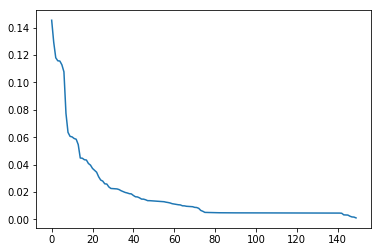

In [21]:
plt.plot(range(len(topics)),topics['weight'])
plt.show()

According to the above chart, we should keep 19 topics.

In [ ]:
# do some testing
x_test = preprocess(x_test,'selftext')

In [134]:
# Create Dictionary
#id2word_test = corpora.Dictionary(x_test['processed'])

# Create Corpus
texts_test = x_test['processed']

# Term Document Frequency
corpus_test = [id2word.doc2bow(text) for text in texts_test]

hdpmodel.evaluate_test_corpus(corpus_test)

-33193677.632195566

In [136]:
# Including topic 0 
test_labels = []
for i in range(len(corpus_test)):
    doc_hdp = hdpmodel[corpus_test[i]]
    if doc_hdp:
        doc_hdp = sorted(doc_hdp, key=lambda tup: tup[1], reverse=True)
        labels = [x for x,y in doc_hdp]
        test_labels.append(labels[0])
    else:
        test_labels.append(9999)

In [137]:
Counter(test_labels)

Counter({0: 5599,
         1: 1349,
         2: 78,
         9999: 25,
         6: 3,
         4: 2,
         74: 1,
         63: 1,
         3: 9,
         16: 1,
         60: 1})

In [141]:
# Not including topic 0
test_labels = []
for i in range(len(corpus_test)):
    doc_hdp = hdpmodel[corpus_test[i]]
    if doc_hdp:
        doc_hdp = sorted(doc_hdp, key=lambda tup: tup[1], reverse=True)
        labels = [x for x,y in doc_hdp]
        if len(labels) > 1:
            if labels[0] == 0:
                test_labels.append(labels[1])
            else:
                test_labels.append(labels[0])
        else:
            test_labels.append(labels[0])
    else:
        test_labels.append(9999)

In [143]:
Counter(test_labels)

Counter({0: 1637,
         1: 4401,
         2: 519,
         6: 20,
         8: 21,
         21: 2,
         9: 6,
         7: 27,
         16: 7,
         9999: 25,
         5: 19,
         3: 143,
         12: 20,
         4: 72,
         13: 14,
         25: 4,
         14: 9,
         17: 6,
         74: 1,
         33: 1,
         10: 29,
         19: 9,
         23: 6,
         63: 2,
         37: 4,
         36: 1,
         15: 7,
         28: 1,
         11: 16,
         24: 3,
         62: 2,
         32: 3,
         20: 4,
         30: 3,
         133: 1,
         18: 5,
         31: 1,
         48: 1,
         103: 1,
         27: 3,
         45: 2,
         22: 2,
         55: 1,
         26: 1,
         35: 1,
         60: 1,
         67: 2,
         112: 1,
         139: 1,
         38: 1})

In [139]:
# label all of our training data
training_labels = []
for i in range(len(corpus)):
    doc_hdp = hdpmodel[corpus[i]]
    if doc_hdp:
        doc_hdp = sorted(doc_hdp, key=lambda tup: tup[1], reverse=True)
        labels = [x for x,y in doc_hdp]
        if len(labels) > 1:
            if labels[0] == 0:
                training_labels.append(labels[1])
            else:
                training_labels.append(labels[0])
        else:
            training_labels.append(labels[0])
    else:
        training_labels.append(9999)

In [115]:
x_train["topic"] = training_labels

In [145]:
# given text story, predict its label and give a random sample of 5 similar stories
def recommend(story_text, id2word):
    # clean the story
    story_text = story_text.translate(str.maketrans('', '', string.punctuation))
    story_text = story_text.lower()
    combined_stops = names.words('male.txt')
    combined_stops.extend(stopwords.words('english'))
    combined_stops.extend(names.words('female.txt'))
    combined_stops = set(combined_stops)
    story_text = ' '.join(y for y in story_text.split() if y not in combined_stops)
    stemmer = PorterStemmer() 
    story_text = [stemmer.stem(y) for y in story_text.split()]
    story_text =  [item for item in story_text if not item.isdigit()]
    
    #print(story_text)
    # convert to BOW model
    corpus = id2word.doc2bow(story_text)
    
    # find predicted label
    doc_hdp = hdpmodel[corpus]
    if doc_hdp:
        doc_hdp = sorted(doc_hdp, key=lambda tup: tup[1], reverse=True)
        labels = [x for x,y in doc_hdp]
        if len(labels) > 1:
            if labels[0] == 0:
                topic = labels[1]
            else:
                topic = labels[0]
        else:
            topic = labels[0]
    else:
        topic = 9999
        
    # return sample of predicted stories
    return topic
    

In [117]:
x_test.head()

,author,selftext,title,processed,processed_text
44407,Trevorwaller81,\n\nI rouse groggily from the vice grip of s...,Fugue,"[rous, groggili, vice, grip, sleep, someth, fe...",rous groggili vice grip sleep someth feel awri...
46597,NightcoreGene,"There's something wrong, really wrong with the...",There's something wrong with the monkeys (Part 1),"[there, someth, wrong, realli, wrong, monkey, ...",there someth wrong realli wrong monkey bare re...
28073,MysteriousPain6,# WARNING: DO NOT READ UNLESS YOU ARE SURE YOU...,The most disturbing discovery I ever had to wi...,"[warn, read, unless, sure, handl, gore, mess, ...",warn read unless sure handl gore mess sexual d...
43634,Witeeeee,"“If the foyer light turns on at night, leave i...","I saw something I shouldn't have, and now its ...","[“if, foyer, light, turn, night, leav, don’t, ...",“if foyer light turn night leav don’t look out...
9266,Aggravatingsuspicion,Originally posted on Monday.\n\nHey everyone. ...,"Re-Update: My Wife is a Psychopath, and My Oth...","[origin, post, monday, hey, everyon, thank, bo...",origin post monday hey everyon thank bottom he...


In [151]:
index = 28073
story_text = x_test['selftext'][index]
story_title = x_test['title'][index]
topic = recommend(story_text,id2word)
recommended = x_train[x_train['topic']==topic]
recommended.head()

,author,selftext,title,processed,processed_text,topic
2649,raginnate2003,"In the day time, people know me as a happy go ...",My Sleep Paralysis Experience,"[day, time, peopl, know, happi, go, lucki, tee...",day time peopl know happi go lucki teenag alwa...,1
35480,poloniumpoisoning,My wife Cass and I are going through the worst...,"Yesterday, I found a little girl crying at my ...","[wife, cass, go, worst, moment, live, alway, s...",wife cass go worst moment live alway saw us pe...,1
2861,Augustus_P,Last part here: https://www.reddit.com/r/nosle...,I work in a hospital in the middle of nowhere ...,"[last, part, httpswwwredditcomrnosleepcomments...",last part httpswwwredditcomrnosleepcommentsaeh...,1
45623,CookooJack,"As far back as I can remember, I’ve hated peop...",The Wishing Well,"[far, back, rememb, i’v, hate, peopl, part, th...",far back rememb i’v hate peopl part they’r ann...,1
38510,Telephantom297,Hi again everyone. I’m really glad you guys li...,I do pest control and for monsters (part 2),"[hi, everyon, i’m, realli, glad, guy, like, fa...",hi everyon i’m realli glad guy like far think ...,1


In [153]:
print(f"Original title: {story_title}")
sampled_titles = recommended.sample(n=5)['title']
print("Here's some recommended titles ...")
for i in sampled_titles:
    print(i)

Original title: The most disturbing discovery I ever had to witness
Here's some recommended titles ...
There is something in the house with me
It's Getting To Be Too Dark (Part One)
The "shadow man"
Little Boys Who Kick And Punch End Up As The Monster's Lunch
I visited heaven, and...


# Appendix

In [ ]:
my_subreddit = subreddit.new(limit=1)
for submission in my_subreddit:
    print(submission.title)
    print('     ')
    all_comments = submission.comments.list()
    for comment in all_comments:
        #print(vars(comment))
        print(comment.body)
        print(comment.author)
        print(comment.likes)
        print('-------')

For the below, follow the directions here https://www.storybench.org/how-to-scrape-reddit-with-python/

In [ ]:
PERSONAL_USE_SCRIPT_14_CHARS = 'you_personal_use_script'
SECRET_KEY_27_CHARS = 'your_secret_key'
YOUR_APP_NAME = 'your_app_name'
YOUR_REDDIT_USER_NAME = 'your_reddit_name'
YOUR_REDDIT_LOGIN_PASSWORD = 'your_password'

In [ ]:
reddit = praw.Reddit(client_id=PERSONAL_USE_SCRIPT_14_CHARS,
                     client_secret=SECRET_KEY_27_CHARS,
                     password=YOUR_REDDIT_LOGIN_PASSWORD,
                     user_agent=YOUR_APP_NAME,
                     username=YOUR_REDDIT_USER_NAME)

In [ ]:
print(reddit.user.me())

In [ ]:
subreddit = reddit.subreddit('nosleep')

In [ ]:
stories_dict = {"story_id": [],
                "title": [],
               "author": [],
               "body": []}

In [ ]:
'''
comments_dict = {"story_id":[],
                "comment_author": [],
                "comment_body": []}
'''

In [ ]:
my_subreddit = subreddit.hot(limit=500)
for submission in my_subreddit:
    stories_dict["title"].append(submission.title)
    stories_dict["body"].append(submission.selftext)
    stories_dict["author"].append(submission.author)
    stories_dict["story_id"].append(submission.id)
    all_comments = submission.comments.list()
    '''
    for comment in all_comments:
        comments_dict["story_id"].append(submission.id)
        comments_dict["comment_body"].append(comment.body)
        comments_dict["comment_author"].append(comment.author)
    '''

In [ ]:
story_df = pd.DataFrame(stories_dict)
story_df.head()

In [ ]:
story_df = story_df.drop([0, 1], )
story_df.head()

In [ ]:
story_df.shape

In [ ]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

In [ ]:
scores = []
for i in range(2,50):
    km = KMeans(n_clusters=i).fit(X)
    labels = km.labels_
    score = silhouette_score(X, labels, metric='cosine')
    scores.append(score)

In [ ]:
plt.plot(range(2,50),scores)
plt.show()

# Comment Analysis

In [ ]:
my_subreddit = subreddit.new(limit=1)
for submission in my_subreddit:
    print(submission.title)
    print('     ')
    all_comments = submission.comments.list()
    for comment in all_comments:
        #print(vars(comment))
        print(comment.body)
        print(comment.author)
        print(comment.likes)
        print('-------')

# Non-negative Matrix Factorization

This method should be disregarded. It takes way too long to run and it's really hard to determine the "right" amount of topics to use. I'm leaving it in here for when we have to write our progress report.

In [10]:
# Make a TF-IDF
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=None, decode_error="replace")
doc_term_matrix = tfidf_vect.fit_transform(story_df['processed'].values)

In [11]:
# Need to tune n_components
errors = []
for i in range(5,100,10):
    print(i)
    nmf = NMF(n_components=i, random_state=42)
    nmf = nmf.fit(doc_term_matrix )
    errors.append(nmf.reconstruction_err_)

5
15
25
35
45
55
65
75
85
95


In [12]:
errors

[185.39558501413458,
 183.25519852563295,
 181.95236838123353,
 180.85081104827208,
 179.8827149141605,
 179.05851195493125,
 178.23408061388184,
 177.40889349999222,
 176.71209153499058,
 176.0112027145298]

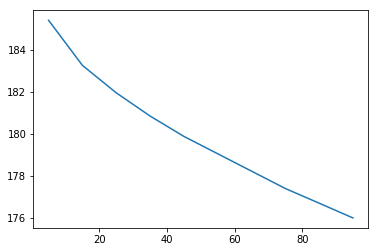

In [13]:
plt.plot(range(5,100,10),errors)
plt.show()